References: <br>https://research-repository.griffith.edu.au/bitstream/handle/10072/21124/39875_1.pdf;sequence=1#:~:text=The%20original%20Meyer%2DWallach%20measure%20Q1%20is%20the%20average%20entanglement,increasing%20size%2C%20and%20the%20rest.
<br>
https://arxiv.org/pdf/1905.10876.pdf
<br>
https://link.springer.com/article/10.1007/s42484-021-00038-w
https://iopscience.iop.org/article/10.1088/1367-2630/ac37c8/pdf

# Imports

In [5]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
import math
import matplotlib.pyplot as plt

# Einleitung

Parametrisierte Quantum Schaltungen (PQC), bei denen die Gates durch veränderbare Parameter definiert sind, sind die Grundbausteine von QML. <br><br>
Beispiel: <br> Einfacher PQC, mit zwei parametrisierten Gates, ein single-qubit z-Rotations Gate mit variablen Winkel $\theta$ und ein two-qubit z-Rotations Gate auch mit der Winkelvariable $\theta$.<br>
In Qiskit sieht das wie folgt aus:

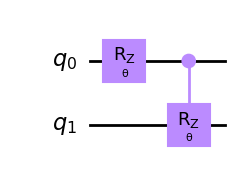

In [3]:
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw(output="mpl")

Oder auch mit zwei verschiedenen Parametern:

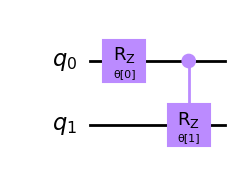

In [6]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw(output="mpl")

Alle Quantum Gates in PQCs sind unitary (umkehrbare Operation, die die Norm bewahrt, sodass Summe der Wahrscheinlichkeiten immer 1 ist).<br>
Ein PQC kann mit einer unitary Operation $U_{\theta}$ auf n Qubits beschrieben werden, die auf die Ursprungszustände $|  \phi_{0}\rangle$ angewendet wird, oft $| 0\rangle ^{\otimes n}$.
<br><br>
Daraus entsteht dann: $|\psi_{\theta}\rangle = U_{\theta} |\phi_{0}\rangle$, wobei $\theta$ ein Vektor mit veränderbaren Parameter beinhaltet.<br>
Hier, bzw. meistens bei QML, sind diese Paramter Winkel für die Rotations Gates, aber können generell auch andere veränderbare Paramter von Quantum Operationen sein.

#### Wie wählen wir den richtigen QS aus?

Um PQCs für ML zu nutzen, müssen sie gut verallgemeinern können.
Das bedeutet, dass der Schaltkreis in der Lage sein sollte, eine signifikante Teilmenge der Zustände innerhalb des Hilbert-Raums der Ausgabe zu erzeugen.
Und der PQC sollte die Qubits zudem entanglen, um einfaches simulieren auf klassischen Computern zu verhindern. 

### Aussagekraft

Die Aussagekraft eines PQC ist im Wesentlichen die Abdeckung des Hilbert-Raums durch den Hypothesenraum des PQC.<br>
<br>
Beispiel: <br>
Wir vergleichen zwei 1-Quibit Schaltungen.

Schaltung A: <br>
Ein Single-Qubit Hadamard Gate gefolt von einem z-Rotations Gate.

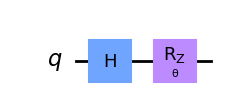

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Schaltung erstellen
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Schaltung A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)


qc_A.draw(output="mpl")

Schaltung B: <br>
Ein Single-Qubit Hadamard Gate gefolt von einem z- und einem x-Rotations Gate.

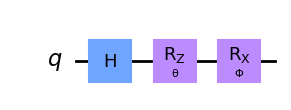

In [9]:
# Schaltung B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

qc_B.draw(output="mpl")

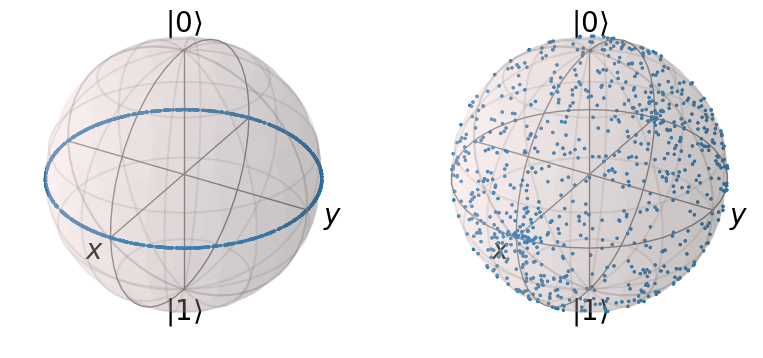

In [14]:
# Der Parameterraum für die beiden Parameter theta und pi wird einheitlich abgetastet
np.random.seed(0)
num_param = 800
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Die Werteliste werden als Zustandsvektoren auf der Bloch Kugel gezeichnet
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

def draw_to_bloch(state_vec):
    # Zustandsvektoren zu Punkte auf Bloch Sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch Plotting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Zustandsvektoren für A und B für die 1000 Parameter bilden und zur Bloch Kugel hinzufügen
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))


b1.show()
b2.show()

Bloch Kugel: Grafisch-geometrische Darstellung der Zustände eines Qubits.
<br>
<br>
A: Zustände nur auf dem Äquator der Bloch-Kugel.<br>
B: Wegen zusätzlichem Rotations-Gate kann ganze Kugel abgedeckt werden.
-> Schaltung B größere Aussagekraft als Scahltung A
<br>
-> Eine 1-Qubit Schaltung hat eine gute Aussagekraft falls sie die "ganze" Bloch Sphere erkunden kann. 

#### Aussagekraft messen

Ein Quantum Circuit $U(\mathbf{x})$, und die Menge
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
Diese Menge ist die Güte der beiden Zustände: 
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

Wir generieren ein paar zufällige Realisierungen von $\mathbf{x},\mathbf{y}$. Das gibt uns eine Menge von zufällig generierten $f$; sodass $F = \{f_{1}, f_{2}, \cdots \}$.

Um die Aussagekraft zu berechnen, müssen wir zwei Sachen machen:
* Ein Histogramm von den Werten in $F$. Die Ausgabe von dem Histogram sieht wie folgt aus: $B = \{(l_1, u_1), (l_2, u_2), \cdots \}$ wobei $l_{j}$ ($u_j$) die untere (obere) Grenze der Teilmenge $j$ ist. Es ergibt sich auch eine empirische Wahrscheinlichkeitsverteilungsfunktion $\mathrm{Pr}_{\text{emp}}(j)$, die einfach aussagt, wie wahrscheinlich es ist, dass ein Wert $f$ in der Teilmenge $j$ drin ist.
* Bei gegebenen Teilmenge vom Histogramm, müssen wir die Wahrscheinlichkeit berechnen, dass eine gegebene Güte in die Teilmenge $j$ fällt, falls die Schaltung, die diese Güte erzeugt, aus einer Haar-Zufallsverteilung gezogen wird. Falls die Schaltung n-Qubits besitzt, ist die Wahrscheinlichkeit einer Güte $f$:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$
Um die Wahrscheinlichkeit über eine Teilmenge des Histogramms zu berechnen, benutzen wir ein Integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$
Die Aussagekraft wird dann als KL-Divergenz zwischen der empirisch beobachteten Wahrscheinlichkeitsverteilung (d. h. dem Histogramm) und der Wahrscheinlichkeitsverteilung geschätzt, die sich bei einer Haar-Zufallsverteilung ergeben würde.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

##### Haar-Zufallsverteilung

Ein Quantum Grundzustand kann als $ |\psi\rangle = \sum_{j=1}^{n} (c_{1j}+ic_{2j})|j\rangle$ beschrieben werden.<br>
Wobei $|j\rangle$ den j-te Orthonomalbasis-Vektor im n-dimensionalen Hilbertraum beschreibt. <br>
$c_{1j}~und~c_{2j}$ sind reelle Zahlen, beschränkt durch die Normalisierungsbedingung $\langle \psi | \psi\rangle = 1$.<br>
Die Haar Verteilung wird dann erreicht, falls man $c_{ij}$ unabhängig voneinander aus einer Gauß-Verteilung mit verschwindendem Mittelwert und endlicher Varianz bestimmt. 

<div>
<img src="images/haar.png" width="300"/>
</div>

n = 3. a) ist Haar-verteilt in einem 3-dim. Hilbertraum (Zustand ist nicht normalisiert).<br> b) (c's aus Gleichverteilung bestimmt) & c) (c's aus Cauchy-Lorentz-Verteilung bestimmt) nicht. 

##### Kullback-Leibler-Divergenz (KL-Divergenz)

Maß für die Unterschiedlichkeit zweier Wahrscheinlichkeitsverteilungen. Auch *relative Entropie* genannt.<br>
KL-Divergenz für Wahrscheinlichkeitsfunktionen P und Q diskreter Werte: <br>
$D(P||Q)=\sum_{x\epsilon X}P(x)*log\frac{P(x)}{Q(x)} = KL(P, Q)$ <br>
Bei Verteilungen für kontinuierliche Werte wird dann ein Integral verwendet.

### Entangling Fähigkeit

Wie ja schon in der Vorlesung besprochen, ist Entanglement ein sehr wichtiges Schlüsselkonzepzt von Quantum Computing.
<br>
Eine Möglichkeit Entanglement zu messen ist die *Meyer-Wallach-Methode*, bei der die durschnittliche Entanglement zwischen zwei Qubits gemessen wird auf der Skala von 0-1. Sie wird häufig benutzt, wegen ihrer skalierbarkeit und einfachen Berechnung. 

##### Meyer-Wallach-Messung
Die Messung kann nur auf Grundzustände von Multi-Qubit Schaltungen, $|\psi \rangle ~ \epsilon ~(\mathbb{C}^2)^{\otimes n}$, angewendet werden.<br>
Für alle j=1,...n und $b~\epsilon ~\{0, 1\}$ definieren wir die linear map $\iota_{j}(b): (\mathbb{C}^2)^{\otimes n}\to (\mathbb{C}^2)^{\otimes n-1}$ mit $\iota_j(b)|x_1\rangle \otimes ... \otimes |x_n\rangle = \delta_{b x_j} |x_1\rangle \otimes ... \otimes |x_{j-1}\rangle \otimes |x_{j+1}\rangle \otimes ...|x_{n}\rangle$
<br>
<br>
$Q(\psi) \equiv \frac{4}{n}\sum_{j=1}^{n} D(\iota_{j}(0)|\psi\rangle, \iota_{j}(1)|\psi\rangle)$
<br>
<br>
mit generalisierten Distanz<br>
$D(|\psi\rangle, |\phi \rangle ) = \langle \psi | \psi\rangle\langle\phi|\phi\rangle - |\langle \psi| \phi\rangle|^2$

Beispiel: <br>
Wieder zwei Schaltungen, dieses mal Multi-Qubit.

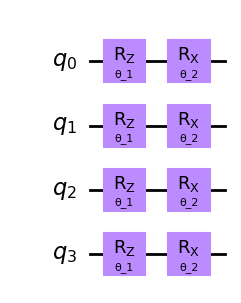

In [14]:
theta1 = Parameter('θ_1')
theta2 = Parameter('θ_2')

# Schaltung A

qc = QuantumCircuit(4)
qc.rz(theta1, 0)
qc.rz(theta1, 1)
qc.rz(theta1, 2)
qc.rz(theta1, 3)
qc.rx(theta2, 0)
qc.rx(theta2, 1)
qc.rx(theta2, 2)
qc.rx(theta2, 3)
qc.draw(output="mpl")

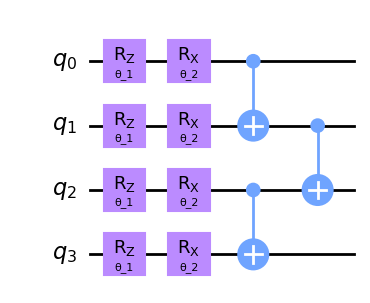

In [19]:
theta1 = Parameter('θ_1')
theta2 = Parameter('θ_2')

# Schaltung B

qc = QuantumCircuit(4)
qc.rz(theta1, 0)
qc.rz(theta1, 1)
qc.rz(theta1, 2)
qc.rz(theta1, 3)
qc.rx(theta2, 0)
qc.rx(theta2, 1)
qc.rx(theta2, 2)
qc.rx(theta2, 3)
qc.cx(0,1)
qc.cx(2,3)
qc.cx(1,2)

qc.draw(output="mpl")

A: Keine Entanglement -> Meyer-Wallach-Messung = 0.<br>
B: Mehrere Entanglements -> Meyer-Wallach-Messung > 0.

### Hardware Effizienz

Geräte haben eine begrenzte Qubit-Konnektivität, Kohärenzzeiten und Gate Fidelities, wirkt sich die Tiefe unserer QS direkt auf die Genauigkeit unserer Ergebnisse aus, da es nur eine begrenzte Fehlerkorrektur / -minderung gibt. 

### PQCs für Machine Learning

In QML werden PQCs typischerweise für zwei Sachen verwendet: <br>
- Für Data Encoding, bei dem die Gate Parameter durch die zu kodierenden Daten bestimmt werden. (kommt im nächsten Kapitel)
- Als Quantenmodell, bei dem die Parameter durch einen Optimierungsprozess bestimmt werden.

<div>
<img src="images/struct1.png" width="400"/>
</div>

<div>
<img src="images/struct2.png" width="400"/>
</div>

#### ZZ-Feature-Map

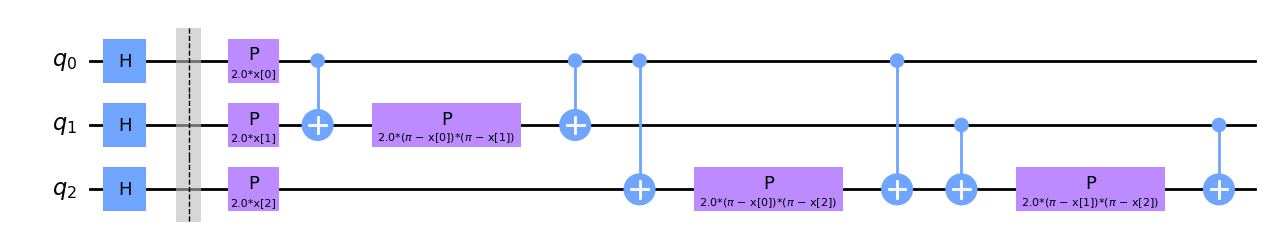

In [1]:
from qiskit.circuit.library import ZZFeatureMap
qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)
qc_zz.decompose().draw(output="mpl")

#### Two-Local

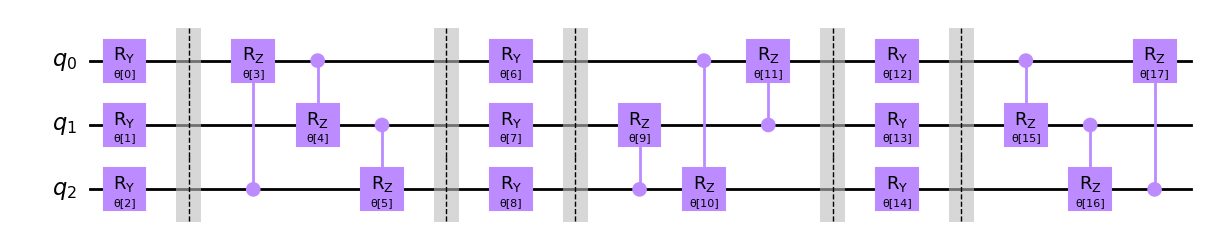

In [3]:
qc_13 = TwoLocal(3, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=3, skip_final_rotation_layer=True,
                 insert_barriers=True)

qc_13.decompose().draw(output="mpl")

#### N-Local

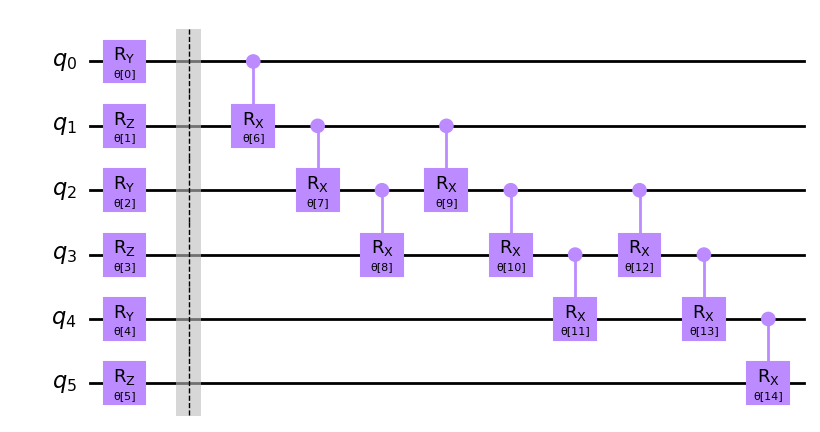

In [6]:
from qiskit.circuit.library import NLocal

# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4)
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

qc_nlocal = NLocal(num_qubits=6, rotation_blocks=rot,
                   entanglement_blocks=ent, entanglement='linear',
                   skip_final_rotation_layer=True, insert_barriers=True)

qc_nlocal.decompose().draw(output="mpl")

# Data Encoding

Bei klassischem ML wird die Data numerisch dargestellt, damit sie von klassichen ML Alg. verarbeitet werden kann.
Bei Quant. ML muss man schauen wie man die Input Data darstellt und effizient an ein einen quant. ML Alg. übergibt.
Wird auch Data Encoding oder Data Emessing / Loading genannt.

Beispiel: Dataset mit M Einträgen, die jeweils N Features haben.
<br>
$X = \{x^{(1)}, ..., x^{(m)}, ..., x^{(M)}\}$


## Basis Encoding

N-bit String zu einem N-qubit System umgewandelt. <br>
$x^{(m)} = (b_{1}, b_{2}, ..., b_{N})$ wird zu $|x^{m}\rangle = |b_{1}, b_{2}, ..., b_{N} \rangle$ mit $b_n \epsilon$ {0, 1} für n = 1, ..., N

$|X\rangle=\frac1{\sqrt{M}} \sum_{i=m}^{M} |x^{m}\rangle$

Beispiel: $x_1$ = 101 und $x_2$ = 111 wird zu $|X\rangle = \frac{1}{\sqrt{2}}*(|101\rangle + |111\rangle)$. (5 & 7) <br>
In Qiskit mit der *initialize* Funktion.

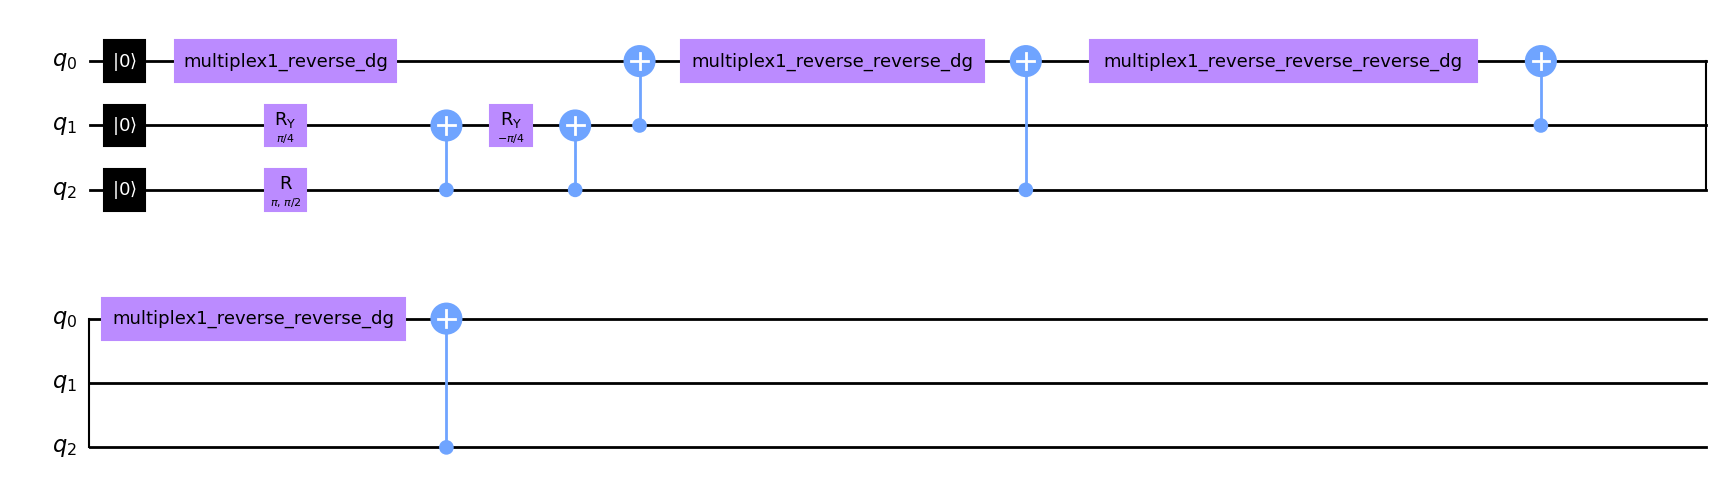

In [7]:
desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw(output="mpl")

## Amplitude Encoding

$|X\rangle = \sum_{i=1}^{N} {\alpha}_i|i\rangle $ mit $\alpha = A_{norm}$ sodass $|\alpha|^2 = 1$
<br>
<br>
Beispiel: $x_1 = (1.5, 0), x_2 = (-2, 3)$
<br>
$a = \frac{1}{\sqrt{15.25}}*(1.5, 0, -2, 3)$
<br>
<br>
$|X\rangle = \frac{1}{\sqrt{15.25}}(1.5|00\rangle-2|10\rangle)+3|11\rangle$

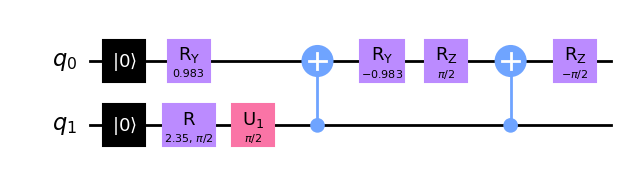

In [6]:
desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose().decompose().decompose().decompose().decompose().draw(output="mpl")

## Angle Encoding

Encodiert N Features zu Drehwinkel von n Qubits (N<=n).<br>
$|x\rangle$ = Tensorprodukt über $cos(x_i)|0\rangle+sin(x_i)|1\rangle$
<br>
<br>
Anders als bei den ersten beiden Encodierungsalg. wird hier nur ein Datanepunkt auf einmal encodiert und nicht das ganze Set.
<br>
<br>
$x = (0, \pi / 4, \pi / 2)$
<br>
Jeweils Single-Quibit Rotation um die Y-Achse mit dem Winkel $2x_j$

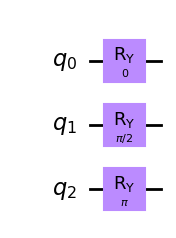

In [5]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2*math.pi/4, 1)
qc.ry(2*math.pi/2, 2)
qc.draw(output="mpl")

## Arbitary Encoding

# Training von param. QS

Allgemein wollen wir eine Cost- oder Lossfunction minimieren. 
Bei QML ist das Ziel den Erwartungswert von $\langle \Psi (\theta)|\hat{H}| \Psi (\theta)\rangle$ zu minimieren. 

Es gibt verschiedene Ansätze und Alg. um die Parameter eines QS zu verbesser.
Wir werden hier die Gradienten Methoden besprechen. 

## Gradienten

Gradient Descent: Einfachste Variante ist, Parameter in Richtung des steilsten Abstiegs des Gradienten upzudaten bis man auf ein lokales Minimum stößt.

<div>
<img src="images/gradient.png" width="500"/>
</div>

Implementierung mit Qiskit: Param. QS definieren. 

In [2]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

Dann Hamilton Matrix definieren

In [3]:
from qiskit.opflow import Z, I
hamiltonian = Z ^ Z

Zusammen ergeben sie den Erwartungswert: $\langle \Psi (\theta)|\hat{H}| \Psi (\theta)\rangle$

In [5]:
from qiskit.opflow import StateFn, PauliExpectation
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Funktion um Erwartungswert zu messen:

In [6]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

Einen Fixpunkt bestimmen.

In [7]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2

## Finite Differenzen Methode

Einfach Variante um den Gradienten abzuschätzen.<br>
Gesucht: Gradient an stelle $\theta$.<br>
Kleine Distanz $\epsilon$ add/sub. und durch die Distanz $2\epsilon$ teilen 

<div>
<img src="images/gradient2.png" width="300"/>
</div>

Implem. mit Qiskit. 

In [10]:
from qiskit.opflow import Gradient

EPS = 0.2

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.040893554687499556

Finite Differenzen Methode kann stark schwanken bei verrauschten Funktionen.

## Analytische Gradienten

## Natürliche Gradienten

## SPSA

# Supervised Learning

Einem Input ein Output zuteilen, basierend auf Beispiel Input-Output Paaren.<br>
*Klassifizierung*: In bestimme Kategorien einteilen.<br>
*Regression*: Beziehung zwischen abhängigen und unabhängigen Variablen, zb. Prediction.

## Quantum Variations Klassifizierung

Gegeben: Input Set X, Quantum Hilbert Raum H.<br>
Datenpunkt werden mit Quantum Feature Map in Quantumzustände encodiert. Diese Zustände werden dann mit dem param. QS verarbeitet und das Ergebnis wird gemäß den Zielzuständen der Ziel-Labels abgeschätzt.

### Implementierung

1. 20 Training Data Punkte und 5 Test Punkte mit 2 Features.

In [21]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)

2. Klassifizierungs Circuit vorbereiten, mit Data Encoding (ZZFeatureMap) und Variations Circuit (TwoLocal, Y und Z Rotation und Kontrol. Phase Gates)

In [22]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐ ░ »
«   q_0: ┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├┤ Rz(θ[10]) ├─░─»
«        ├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤├───────────┤ ░ »
«   q_1: ┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─»
«        └──────────┘   └──────────┘└──────────┘   └──────────┘└───────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌─┐   
«   q_0: ┤M├───
«        └╥┘┌─┐
«   q_1: ─╫─┤M├
«         ║ └╥┘
«meas: 2/═╩══╩═
«         0  1

3. Funktion erstellen, die die Daten auf die Feature Map und die var. Params. auf den Vari. Circuit mappt.

In [23]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

4. Parität des geg. Bit String berechnen. Anzahl an 1er bits gerade/ungerade)

In [36]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [37]:
print(parity("1101"))
print(parity("1001"))

0
1


In [38]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [39]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [40]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [ ]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [ ]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

In [ ]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Implementierung mit Qiskit

1. OneHot Encoden der Labels

In [42]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

2. VQC Alg.

In [1]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

NameError: name 'np' is not defined

Plotten

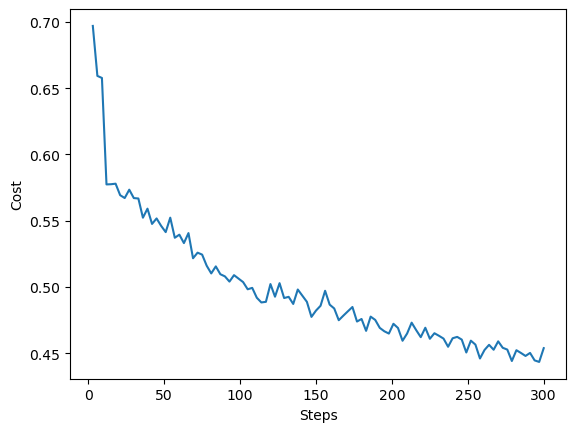

In [44]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

VQC mit den Test Datenpunkten 

In [45]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

0.9

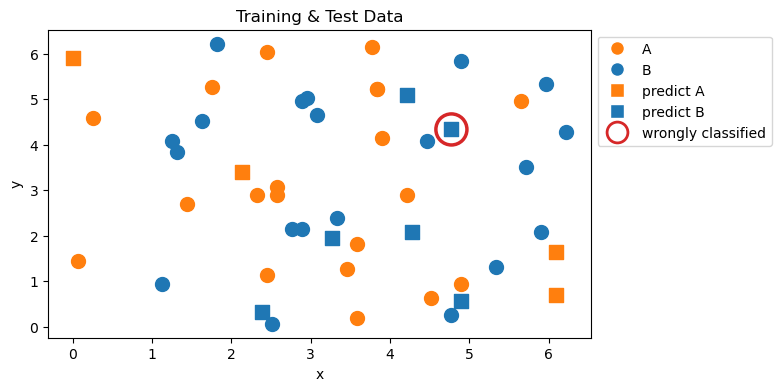

In [47]:
from matplotlib.lines import Line2D
plt.figure(figsize=(7, 4))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Performance vom VQC ziemlich gut mit den Testdatenpunkten. 

### Variations Training

Die perfekten Parameter für den VQC zu finden benötigt die meiste Rechenzeit. <br>
Es kann auch passieren, dass die Opt. Methode nur ein lokales Minimum statt dem globalen Minimum findet, falls die Loss-Landschaft ziemlich komplex ist. 

<div>
<img src="images/vqc.png" width="300"/>
</div>

## Quantum Feature Maps und Kernels

#### Feature Maps

Eine Q.Feature Map mappt einen klassischen Feature Vektor auf den Hilbert Raum. Indem sie x mit einer Unitary Transformation transformiert (param. QS).

In [48]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data
train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3,
                include_sample_total=True, one_hot=False))

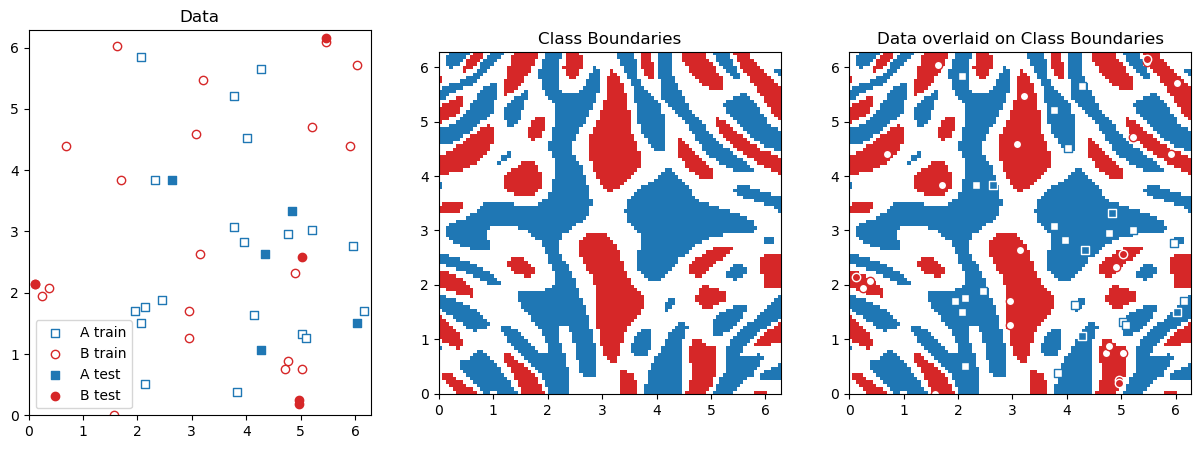

In [49]:
# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)
plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='C0',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='C3',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='C0', label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='C3', label="B test")
plt.legend()

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["C3","w","C0"])
axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap=cmap,
             extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth = fig.add_subplot(133)
axboth.set_title("Data overlaid on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap=cmap,
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='C0', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='C3', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='C0', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='C3', edgecolors='w',
               label="B test")
plt.show()

Links: 25 2D Datenpunkte
<br> 
Mitte: 2D Projektion des 16D Feature Raums von der ZZFeatureMap.
<br>
Rechts: Links und Mitte kombiniert.

#### Kernels

Feature Map $\phi (x)$ mit Kernel Matrix: $K_{ij}=|\langle \phi ^T (x_j) | \phi (x_i) \rangle|^2$

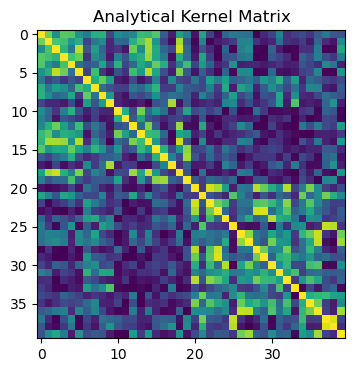

In [51]:
from qiskit import opflow
def calculate_kernel(feature_map, x_data, y_data=None):
    """
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated.
        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """
    if y_data is None:
        y_data = x_data
    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each data point
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        )
    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
kernel = calculate_kernel(adhoc_feature_map, train_data)
plt.figure(figsize=(4, 4))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

## Quantum Kernel Schätzung

Gegeben: Input Set X, Quantum Hilbert Raum H.<br>
Innere Produkt von zwei Quanten Encodierten Quantenzuständen bilden einen Kernel, der wie ein Kernel im klassischen Machine Learning fungiert.